# Application of Bootstrap samples in Random Forest

In [0]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### 1. Load the boston house dataset

In [0]:
boston = load_boston()
X=boston.data #independent variables
y=boston.target #target variable

In [9]:
print(X.shape)
print(y.shape)

(506, 13)
(506,)


## Task 1

### 2. Creating samples

In [0]:
import random
def create_sample(data_x,data_y):
    #col = np.random.randint(1,10)
    size_1 = int((len(data_x))* (60/100))
    random_indices = random.sample(range(len(data_x)), size_1)
    sample_1_x = data_x[random_indices,:]
    sample_1_y = data_y[random_indices]
    
    size_2 = len(data_x)-size_1
    random_indices1 = random.sample(range(len(sample_1_x)), size_2)
    sample_2_x = sample_1_x[random_indices1,:]
    sample_2_y = sample_1_y[random_indices1]
    
    main_sample_x = np.concatenate((sample_1_x , sample_2_x ))
    main_sample_y = np.concatenate((sample_1_y , sample_2_y ))
    return main_sample_x , main_sample_y, random_indices

In [0]:
def create_30 (data_x,data_y) :
    x_list = []
    y_list = []
    selected_Ind=[]
    selected_Col=[]
    no_of_sample = 30
    for i in range (no_of_sample) :
        sample_x, sample_y, selIdx = create_sample(data_x,data_y)
        selected_Ind.append(selIdx)
        col_num = np.random.randint(3,14)
        # col_num = round(13 * ratio)
        selCol=random.sample(range(0,13), col_num)
        selected_Col.append(selCol)
        s = sample_x[:,selCol]
        x_list.append(s)
        y_list.append(sample_y)
        
    return x_list, y_list, selected_Ind, selected_Col

In [42]:
sample_x , sample_y, selected_Ind, selected_Col = create_30 (X,y)
len(sample_x)

30

In [0]:
# applied decision tree regressor on 30 samples n model saved in a list
from sklearn.tree import DecisionTreeRegressor
def TrainDTR(sample_x,sample_y):
    no_of_samples = len(sample_x)
    AllregTree=[]
    
    for sm in range(no_of_samples):
        sx=sample_x[sm]
        sy=sample_y[sm]
        
        regressor = DecisionTreeRegressor( max_depth=None )
        #regressor = DecisionTreeRegressor()
        reg =regressor.fit(sx,sy)
        AllregTree.append(reg)
        
    return AllregTree

In [0]:
def main_function_MSE(sx, sy, AllregTree, selCol):
    mseList=[]
    mse=[]
  
    for r in range(len(sx)):
        srow=sx[r].reshape(1,-1)
        yrow=sy[r]
        y_predicted=[]
        for art in range(len(AllregTree)):
            scol=np.array(selCol[art])
            reg =AllregTree[art]
            serow=srow[0,scol].reshape(1,-1)
            preY=reg.predict(serow)
            y_predicted.append( preY )
               
        yp = np.mean(y_predicted)
                
        mse.append( (yrow - yp)**2)
    mseList.append(np.mean(mse))
    return mseList

In [43]:
AllregTree = TrainDTR(sample_x,sample_y)
mse_30_list = main_function_MSE(X,y, AllregTree, selected_Col)
print("\n The Mean Standard Error of randomly created 30 samples is :")
print(mse_30_list)


 The Mean Standard Error of randomly created 30 samples is :
[2.3781190890365003]


In [0]:
def main_function_OOB(sx, sy, AllregTree, selInd, selCol):
    oobList=[]

    oob=[]
    
    for r in range(len(sx)):
        srow=sx[r].reshape(1,-1)
        yrow=sy[r]
        y_predicted=[]
        for art in range(len(AllregTree)):
            sidx=selInd[art]
            if r in sidx:
                continue
            scol=np.array(selCol[art])
            reg =AllregTree[art]
            serow=srow[0,scol].reshape(1,-1)
            y_predicted.append( reg.predict(serow))
               
        yp = np.mean(y_predicted)
                
        oob.append( (yrow - yp)**2)

       
    oobList.append(np.mean(oob))
        
    return oobList

In [44]:
oob_30_list = main_function_OOB(X,y, AllregTree, selected_Ind, selected_Col)
print("\n The oob score of randomly created 30 samples is :")
print(oob_30_list)


 The oob score of randomly created 30 samples is :
[13.424591669111669]


## Task 2 : Computing CI of OOB Score and Train MSE

In [0]:
def calculate_Train_MSE_OOB (X,y, AllregTree, selected_Ind, selected_Col):
    train_MSE = []
    train_OOB = []
    no_of_iteration = 35
    for r in range(no_of_iteration):
        new_mse = main_function_MSE(X,y, AllregTree, selected_Col)
        new_oob = main_function_OOB(X,y, AllregTree, selected_Ind, selected_Col)
        train_MSE.append(new_mse) 
        train_OOB.append(new_oob)
    return train_MSE, train_OOB

In [0]:
train_mse_list,train_oob_list = calculate_Train_MSE_OOB (X,y, AllregTree, selected_Ind, selected_Col)

In [46]:
MSE = np.array(train_mse_list)
OOB =np.array(train_oob_list)
MSE.shape, OOB.shape

((35, 1), (35, 1))

In [0]:
mean_mse = np.mean(MSE)
std_mse= np.std(MSE)
std_error_mse = std_mse/np.sqrt(len(MSE))
left_limit_mse  = mean_mse - 2*(std_error_mse)
right_limit_mse = mean_mse + 2*(std_error_mse)
catch_mse =(mean_mse <= right_limit_mse) and (mean_mse >= left_limit_mse)

mean_oob = np.mean(OOB)
std_oob = np.std(OOB)
std_error_oob = std_oob/np.sqrt(len(OOB))
left_limit_oob  = mean_oob - 2*(std_error_oob)
right_limit_oob = mean_oob + 2*(std_error_oob)
catch_oob =(mean_oob <= right_limit_oob) and (mean_oob >= left_limit_oob)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
def plt_confidence_interval(data, sample_mean, population_std, color1):
    sns.distplot(data, color=color1)
    plt.axvline(data.mean(), linestyle="-", color='k', label="p_mean")
    plt.axvline(sample_mean, linestyle="--", color='m', label="s_mean")
    plt.axvline(sample_mean+2*(population_std/np.sqrt(100)), linestyle=":", color='g', label="s_mean+2*SE")
    plt.axvline(sample_mean-2*(population_std/np.sqrt(100)), linestyle=":", color='g', label="s_mean-2*SE")
    plt.legend()

### 3. Graph plot for Train MSE List

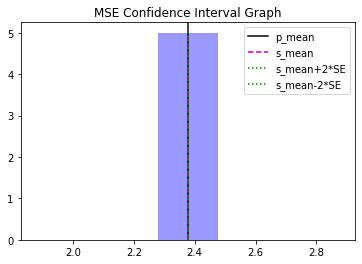

In [49]:
colrs =['blue','pink']
plt_confidence_interval(MSE, mean_mse , std_error_mse, colrs[0])
plt.title("MSE Confidence Interval Graph")
plt.show()

### 4. Graph plot for Train OOB List

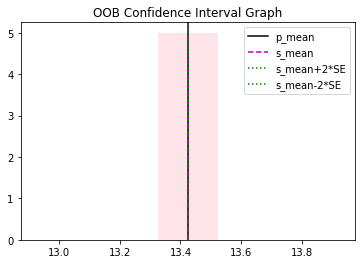

In [50]:
plt_confidence_interval(OOB, mean_oob , std_error_oob, colrs[1])
plt.title("OOB Confidence Interval Graph")
plt.show()

In [51]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("#samples", "Sample Size", "Sample mean", " Std error","Left C.I","Right C.I","Catch")
tb.add_row(["MSE ",len(MSE), mean_mse ,std_error_mse,left_limit_mse,right_limit_mse,catch_mse ])
tb.add_row([" OOB ",len(OOB),mean_oob,std_error_oob,left_limit_oob,right_limit_oob,catch_oob])

print(tb.get_string(titles = "Confidence Interval for MSE and OOB"))

+----------+-------------+--------------------+------------------------+--------------------+--------------------+-------+
| #samples | Sample Size |    Sample mean     |        Std error       |      Left C.I      |     Right C.I      | Catch |
+----------+-------------+--------------------+------------------------+--------------------+--------------------+-------+
|   MSE    |      35     | 2.3781190890365003 |          0.0           | 2.3781190890365003 | 2.3781190890365003 |  True |
|   OOB    |      35     | 13.42459166911167  | 3.0025910814704436e-16 | 13.42459166911167  | 13.42459166911167  |  True |
+----------+-------------+--------------------+------------------------+--------------------+--------------------+-------+


## Task 3 : with single query point predict the price of house

In [0]:
xq= [0.18,20.0,5.00,0.0,0.421,5.60,72.2,7.95,7.0,30.0,19.1,372.13,18.60]
xq_array = np.asarray(xq)
query_point = xq_array.reshape(1,-1)
xq_size = query_point.shape[1]

In [31]:

for r in range(len(X)):
        
        y_predicted=[]
        for art in range(len(AllregTree)):
            scol=np.array(selected_Col[art])
            reg =AllregTree[art]
            serow=xq_array[scol].reshape(1,-1)
            preY=reg.predict(serow)
            y_predicted.append( preY )
               
        y_pred_mean = np.mean(y_predicted)
        
print("Predicted house price value for above query point is :", y_pred_mean)

Predicted house price value for above query point is : 19.163055555555555
